# Anwendungsbeispiel: Ridge Regression vs. SVM
<p></p>
    
<div style="text-align:justify">
In diesem Anwendungsbeispiel vergleichen wir <em>Ridge Regression</em> mit einer <em>C-SVM</em>. Die Daten wurden künstlich erstellt und dienen nur als Veranschaulichung einer potentiellen "echten" Anwendung.
</div>

## Erläuterung der (Toy-)Anwendung  
<p></p>
    
<div style="text-align:justify">
Ein neues Medikament kommt auf den Markt, welches sich gut für die Therapie eines speziellen Tumors eignet. Jedoch hat man festgestellt, dass es bei einer Gruppe von Patienten schneller wirkt als bei einer anderen. Leider kommt es bei einer längeren Behandlung mit dem Medikament zu erheblichen Nebenwirkungen. Daher möchte man vermeiden, dass Patienten das Medikament verabreicht wird, wenn es eine zu lange Reaktionszeit benötigen würde. 
</div>
<br>
<div style="text-align:justify">
Es wird vermutet, dass verschiedene genetische Veränderungen (Mutationen) im Genom der einzelnen Patienten eine Rolle spielen könnten, weshalb das Medikament eine schnellere oder längere Reaktionszeit hat. 
</div>
<br>
<div style="text-align:justify">
Unsere Aufgabe als <em>Machine Learner</em> ist es nun ein Vorhersagemodell zu entwickeln, welches uns anhand der genetischen Unterschiede zwischen den Patienten die Reaktionszeit (Anzahl der Tage) vorsagt, ab wann das Medikament für den individuellen Patienten zu wirken beginnt. 
</div>
<br>
<div style="text-align:justify">
Um die Reaktionszeit in Tagen vorherzusagen bekommen wir von unserem Auftragssteller einen Datensetz von 400 Patienten. Für jeden Patienten wurden 600 verschiedene genetische Veränderungen (Mutationen) an derselben Stelle im Genom gemessen. Zusätzlich wurde die Anzahl der Tage notiert ab wann das Medikament für den individuellen Patient begonnen hat zu wirken.
</div>


## 1. Vorhersage der genauen Reaktionszeit mit Ridge Regression
<div style="text-align:justify">
Um die Reaktionszeit des Medikaments für neue Patienten vorherzusagen, verwenden wir <em>Ridge Regression</em>, da es sich um ein Regressionproblem handelt und wir mehr Features als Patienten haben. Zudem verwenden wir Ridge Regression um ein Model zu lernen, welches nicht überangepasst ist (<em>overfitted</em>) und gut auf unbekannte Patienten generalisiert, indem wir den optimalen Regularisierungsparameter lernen.
</div>
### 1.1 Daten Vorverarbeitung

In [1]:
%matplotlib inline
import scipy as sp
import matplotlib
import pylab as pl
matplotlib.rcParams.update({'font.size': 15})

from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV,StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, r2_score

random_state = 42

#Lade Simulierte Daten
data = sp.loadtxt("toydata/X.txt")
binary_target = sp.loadtxt("toydata/y_binary.txt")
continuous_target = sp.loadtxt("toydata/y.txt")

#Zusammenfassung der Daten
print("Orginal Daten")
print("Anzahl Patienten:\t%d"%data.shape[0])
print("Anzahl Features:\t%d"%data.shape[1])
print

#Splitte Daten in Trainings und Test Daten
train_test_data = train_test_split(data,
                                   continuous_target,
                                   test_size=0.2,
                                   random_state=random_state)
training_data = train_test_data[0]
testing_data = train_test_data[1]
training_target = train_test_data[2]
testing_target = train_test_data[3]

print("Trainingsdaten")
print("Anzahl Patienten:\t%d"%training_data.shape[0])
print("Anzahl Features:\t%d"%training_data.shape[1])
print
print("Testdaten")
print("Anzahl Patienten:\t%d"%testing_data.shape[0])
print("Anzahl Features:\t%d"%testing_data.shape[1])

Orginal Daten
Anzahl Patienten:	400
Anzahl Features:	600

Trainingsdaten
Anzahl Patienten:	320
Anzahl Features:	600

Testdaten
Anzahl Patienten:	80
Anzahl Features:	600


### 1.2 Verwende Ridge Regression

5-fache Kreuzvalidierung mit interne Liniensuche auf Trainingsdaten
Durchschnitt(R2):		0.30 (-+ 0.04)

Ergebnisse mit optimalem Alpha auf Testdaten
R2 (Test Daten, Alpha=Optimal):	0.17 
Optimales Alpha:		100000.00



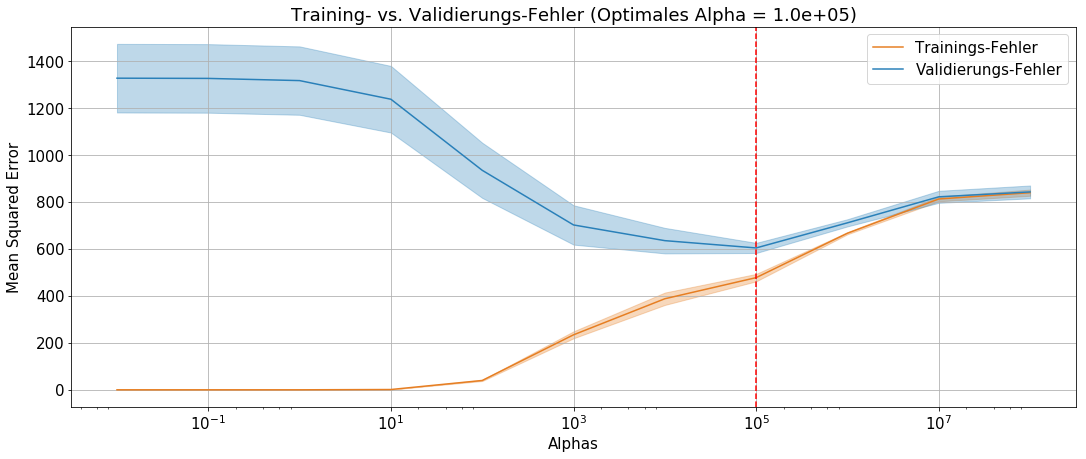

In [2]:
#Initialisiere Alphas für Ridge Regression
alphas = sp.logspace(-2,8,11)
param_grid = dict(alpha=alphas)

#5-fach Kreuzvalidierung um den mittleren R2 score zu berechnen
outer_cv = KFold(n_splits=5,shuffle=True,random_state=random_state)

#Liniensuche um das optimale Alpha zu finden
line_search = GridSearchCV(Ridge(random_state=random_state,solver="cholesky"),
                           param_grid=param_grid,
                           scoring="neg_mean_squared_error")

#Führe 5-fach Kreuzvalidierung mit interner Liniensuche aus und berechne mittleren R2
score = cross_val_score(line_search,X=training_data,y=training_target,cv=outer_cv,scoring="r2")
print("5-fache Kreuzvalidierung mit interne Liniensuche auf Trainingsdaten")
print("Durchschnitt(R2):\t\t%.2f (-+ %.2f)"%(score.mean(),score.std()))
print

#Berechne optimales Alpha auf allen Trainings Daten
line_search.fit(training_data,training_target)
optimal_alpha = line_search.best_params_['alpha']

#Trainiere Ridge Regression auf allen Trainings Daten mit optimalen Alpha
model = Ridge(alpha=optimal_alpha,solver="cholesky")
model.fit(training_data,training_target)

#Sage auf unbekannten Test Daten vorher
predictions = model.predict(testing_data)
print("Ergebnisse mit optimalem Alpha auf Testdaten")
print("R2 (Test Daten, Alpha=Optimal):\t%.2f "%(r2_score(testing_target,predictions)))
print("Optimales Alpha:\t\t%.2f"%optimal_alpha)
print

#Visualisiere Trainings und Validierungs Fehler für unterschiedliche Alphas
pl.figure(figsize=(18,7))
pl.plot(alphas,line_search.cv_results_['mean_train_score']*(-1),label="Trainings-Fehler",color="#e67e22")
pl.fill_between(alphas,
                line_search.cv_results_['mean_train_score']*(-1)-line_search.cv_results_['std_train_score'],
                line_search.cv_results_['mean_train_score']*(-1)+line_search.cv_results_['std_train_score'],
                alpha=0.3,color="#e67e22")
pl.plot(alphas,line_search.cv_results_['mean_test_score']*(-1),label="Validierungs-Fehler",color="#2980b9")
pl.fill_between(alphas,
                line_search.cv_results_['mean_test_score']*(-1)-line_search.cv_results_['std_test_score'],
                line_search.cv_results_['mean_test_score']*(-1)+line_search.cv_results_['std_test_score'],
                alpha=0.3,color="#2980b9")
#pl.xlim(0,max(alphas))
pl.xscale("log")
pl.ylabel("Mean Squared Error")
pl.xlabel("Alphas")
pl.legend(frameon=True)
pl.grid(True)
pl.axvline(x=optimal_alpha,color='r',linestyle="--")
pl.title("Training- vs. Validierungs-Fehler (Optimales Alpha = %.1e)"%optimal_alpha);

<br>
<div style="text-align:justify">
Eine 5-fache Kreuzvalidierung auf den Trainingsdaten führt zu einem Bestimmtheitsmaß von $R^2=0.30 \pm 0.04$. Auf den Testdaten erhalten wir eine Performance von $R^2=0.17$. Ridge Regression beschreibt unsere Daten eher schlecht (trotz Parameteroptimierung).  
Das kann, z.B. daran liegen, dass es  schwer ist mit den vorhandenen Features die Variation in unserer Zielvariable (Anzahl der Tage bis Medikament wirkt) zu beschreiben.  
Das bedeuted, dass unserem Model die genauen Tage bis das Medikament wirk nur ungau verhersagen kann!
</div>
<br>
<div style="text-align:justify">
Wegen der eher entäuschenden Ergebnisse, besprechen sich unsere Auftragsgeber nochmals. Nach längerer Beratung erklärt uns unser Auftragsgeber, dass es ihm eigentlich nicht auf die genauen Anzahl der Tage ankommt. Vielmehr würde ihnen ausreichen, wenn wir die Patienten vorhersagen könnten, welche eine längere Reaktionszeit haben und welche eine kürzere.  
Laut den Erfahrungen unseres Auftraggebers ist ab circa 50 Tagen Anwendung mit erheblichen Nebenwirkungen zu rechen. Wir binarisieren unsere Daten indem alle Patienten mit bis zu 50 Tage in Klasse 0 und alle Patiente mit mehr als 50 Tagen in Klasse 1 aufgeteilt werden.  
Somit können wir statt einer Regression einen Klassifikationsalgorithmus verwenden, welcher versucht die Patienten in diese zwei unterschiedlichen Klassen zu klassifizieren.
</div>
## 2. Vorhersage von Patienten mit Langsamer vs. Schneller Reaktionszeit mit einer Support-Vector-Machine

### 2.1 Daten Vorverarbeitung

In [3]:
#Splitte Daten in Trainings und Test Daten unter Einhaltung der Klassen Ratio
stratiefied_splitter = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in stratiefied_splitter.split(data,binary_target):
    training_data = data[train_index,:]
    training_target = binary_target[train_index]
    testing_data = data[test_index,:]
    testing_target = binary_target[test_index]

print("Trainingsdaten")
print("Anzahl Patienten:\t\t%d"%training_data.shape[0])
print("Anzahl Features:\t\t%d"%training_data.shape[1])
print("Anzahl Patienten Klasse 0:\t%d"%(training_target==0).sum())
print("Anzahl Patienten Klasse 1:\t%d"%(training_target==1).sum())
print
print("Testdaten")
print("Anzahl Patienten:\t\t%d"%testing_data.shape[0])
print("Anzahl Features:\t\t%d"%testing_data.shape[1])
print("Anzahl Patienten Klasse 0:\t%d"%(testing_target==0).sum())
print("Anzahl Patienten Klasse 1:\t%d"%(testing_target==1).sum())

Trainingsdaten
Anzahl Patienten:		320
Anzahl Features:		600
Anzahl Patienten Klasse 0:	160
Anzahl Patienten Klasse 1:	160

Testdaten
Anzahl Patienten:		80
Anzahl Features:		600
Anzahl Patienten Klasse 0:	40
Anzahl Patienten Klasse 1:	40


### 2.2 Klassifikation mit einer linearen SVM

5-fache Kreuzvalidierung mit interne Liniensuche auf Trainingsdaten
Durchschnitt(Accuracy):			0.77 (-+ 0.06)

Vorhersage Ergebniss mit optimalen C
Accuracy (Test Daten, C=Optimal):	0.82 
Optimales C:				1.00e-04



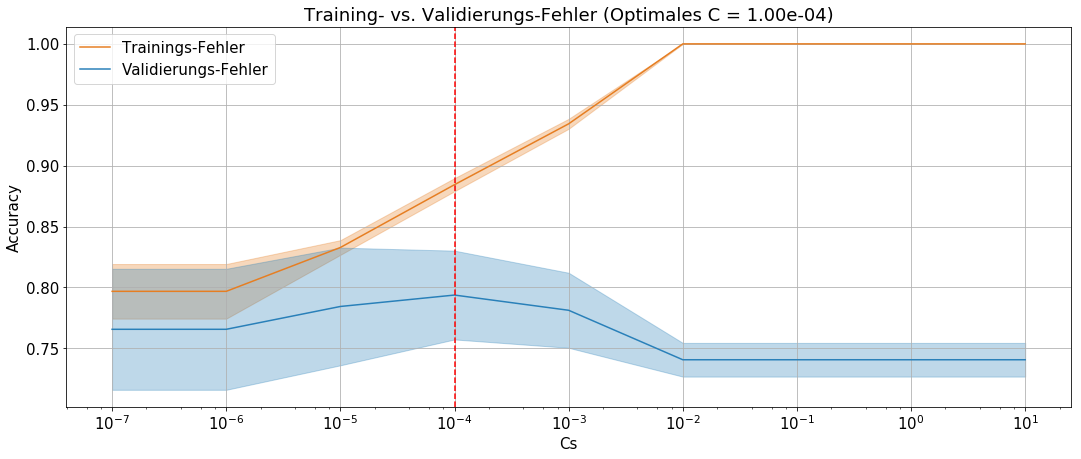

In [4]:
Cs = sp.logspace(-7, 1, 9)
param_grid = dict(C=Cs)

grid = GridSearchCV(SVC(kernel="linear",random_state=random_state),
                    param_grid=param_grid,
                    scoring="accuracy",
                    n_jobs=4)
outer_cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=random_state)

#Perform 5 Fold cross-validation with internal line-search and report average Accuracy
score = cross_val_score(grid,X=training_data,y=training_target,cv=outer_cv,scoring="accuracy")
print("5-fache Kreuzvalidierung mit interne Liniensuche auf Trainingsdaten")
print("Durchschnitt(Accuracy):\t\t\t%.2f (-+ %.2f)"%(score.mean(),score.std()))
print
grid.fit(training_data,training_target)
optimal_C = grid.best_params_['C']

model = SVC(C=optimal_C,random_state=random_state,kernel="linear")
model.fit(training_data,training_target)
predictions = model.predict(testing_data)
print("Vorhersage Ergebniss mit optimalen C")
print("Accuracy (Test Daten, C=Optimal):\t%.2f "%(accuracy_score(testing_target,predictions)))
print("Optimales C:\t\t\t\t%.2e"%optimal_C)
print


pl.figure(figsize=(18,7))
pl.plot(Cs,grid.cv_results_['mean_train_score'],label="Trainings-Fehler",color="#e67e22")
pl.fill_between(Cs,
                grid.cv_results_['mean_train_score']-grid.cv_results_['std_train_score'],
                grid.cv_results_['mean_train_score']+grid.cv_results_['std_train_score'],
                alpha=0.3,color="#e67e22")
pl.plot(Cs,grid.cv_results_['mean_test_score'],label="Validierungs-Fehler",color="#2980b9")
pl.fill_between(Cs,
                grid.cv_results_['mean_test_score']-grid.cv_results_['std_test_score'],
                grid.cv_results_['mean_test_score']+grid.cv_results_['std_test_score'],
                alpha=0.3,color="#2980b9")
#pl.xlim(0,max(Cs))
pl.ylabel("Accuracy")
pl.xlabel("Cs")
pl.xscale("log")
pl.legend(frameon=True)
pl.grid(True)
pl.axvline(x=optimal_C,color='r',linestyle="--")
pl.title("Training- vs. Validierungs-Fehler (Optimales C = %.2e)"%optimal_C);

### 2.3 Klassifikation mit einer SVM mit RBF Kern


In [5]:
Cs = sp.logspace(-4, 4, 9)
gammas = sp.logspace(-7, 1, 9)
param_grid = dict(C=Cs,gamma=gammas)

grid = GridSearchCV(SVC(kernel="rbf",random_state=42),
                    param_grid=param_grid,
                    scoring="accuracy",
                    n_jobs=4)

outer_cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=random_state)

#Perform 5 Fold cross-validation with internal line-search and report average R2
score = cross_val_score(grid,X=training_data,y=training_target,cv=outer_cv,scoring="accuracy")
print("5-fache Kreuzvalidierung mit interne Liniensuche auf Trainingsdaten")
print("Durchschnitt(Accuracy):\t\t\t%.2f (-+ %.2f)"%(score.mean(),score.std()))
print

grid.fit(training_data,training_target)
optimal_C = grid.best_params_['C']
optimal_gamma = grid.best_params_['gamma']

model = SVC(C=optimal_C,gamma=optimal_gamma,random_state=42,kernel="rbf")
model.fit(training_data,training_target)
predictions = model.predict(testing_data)
print("Vorhersage Ergebniss mit optimalen C")
print("Accuracy (Test Daten, C=Optimal):\t%.2f "%(accuracy_score(testing_target,predictions)))
print("Optimales C:\t\t\t\t%.2e"%optimal_C)
print("Optimales Gamma:\t\t\t%.2e"%optimal_gamma)
print

5-fache Kreuzvalidierung mit interne Liniensuche auf Trainingsdaten
Durchschnitt(Accuracy):			0.85 (-+ 0.07)

Vorhersage Ergebniss mit optimalen C
Accuracy (Test Daten, C=Optimal):	0.93 
Optimales C:				1.00e+01
Optimales Gamma:			1.00e-05

